### Neural Networks - Keras

Functionality through a structured layers approach:

- Input Layer: Collects sensory information (e.g., hearing, touching).
- Hidden Layers: Two layers process inputs into emotions and feelings.
- Output Layer: Generates decisions or actions based on processed inputs.
This model offers a simplified view of the complex decision-making processes in the human brain.

Most common types of neural networks (neural network trading):

- Perceptron
- Feed forward neural networks
- Multilayer perceptron
- Convolutional neural network
- Recurrent neural network
- Modular neural network

Source:
- https://blog.quantinsti.com/neural-network-python/

#### How to train a neural network?

We'll train a neural network to predict stock prices using historical OHLCV (Open, High, Low, Close, Volume) data. Here’s an overview of the process:

1. Training Approaches:
 - Rule-Based: Define rules for outputs based on inputs.
 - Model Training: Adjust weights on a dataset to improve predictions.
2. Dataset Structure:
 - Inputs: OHLCV data.
 - Output: Next day’s Close price (actual y and predicted y').
3. Cost Function:
 - Measures prediction error:
  $$ C = \sum_{}^{}\frac{1}{2}(\widehat{y}-y)^{2} $$
 - Objective: Minimize this cost.
4. Training Process:
 - Compute initial cost with a set of weights.
 - Adjust weights using backpropagation to reduce the cost iteratively.
5. Optimization:
 - Evaluate cost across multiple weight configurations to find the best ones.

By refining weights based on error, the neural network learns to predict stock prices effectively.

In [ ]:
pip install yfinance

In [39]:
# Ta-lib is a technical analysis library, which will be used to compute the RSI and Williams %R. 
# These will be used as features in order to train our artificial neural network or ANN.
# Instructions for the Installation: https://blog.quantinsti.com/install-ta-lib-python/
# https://github.com/cgohlke/talib-build/releases -> Install ta_lib-0.6.3-cp313-cp313-win_amd64.whl On Windows win_amd64

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import random
import talib

In [ ]:
# Ensure reproducibility
random.seed(42)

# Download stock data
price_stock = yf.download('AAPL', start='2017-11-06', end='2023-01-03', auto_adjust=True)

# Check if data is downloaded successfully
if price_stock.empty:
    print("Error: No data downloaded. Please check the ticker symbol or internet connection.")
else:
    # Preparing the dataset - Inputs
    price_stock['H-L'] = price_stock['High'] - price_stock['Low']
    price_stock['O-C'] = price_stock['Close'] - price_stock['Open']
    price_stock['3day MA'] = price_stock['Close'].shift(1).rolling(window=3).mean()
    price_stock['10day MA'] = price_stock['Close'].shift(1).rolling(window=10).mean()
    price_stock['30day MA'] = price_stock['Close'].shift(1).rolling(window=30).mean()
    price_stock['Std_Dev'] = price_stock['Close'].rolling(5).std()
    price_stock['RSI'] = talib.RSI(price_stock['Close'].values.flatten(), timeperiod=9)
    price_stock['Williams %R'] = talib.WILLR(
        price_stock['High'].values.flatten(),
        price_stock['Low'].values.flatten(),
        price_stock['Close'].values.flatten(),
        7
    )

    # Output Values - Price Rise or Fall
    price_stock['Price_Rise'] = np.where(price_stock['Close'].shift(-1) > price_stock['Close'], 1, 0)

    # Drop rows with NaN values
    price_stock = price_stock.dropna()

    # Check if the dataset is not empty after preprocessing
    if price_stock.empty:
        print("Error: Dataset is empty after preprocessing. Please check the feature engineering steps.")
    else:
        # Define input features (X) and target variable (y)
        X = price_stock.iloc[:, 4:-1]
        y = price_stock.iloc[:, -1]

        # Split the dataset into training and testing sets
        split = int(0.8 * len(X))
        X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

        # Check if training data is not empty
        if X_train.empty or y_train.empty:
            print("Error: Training data is empty. Please check the data splitting logic.")
        else:
            # Standardize the input features
            from sklearn.preprocessing import StandardScaler
            sc = StandardScaler()
            X_train = sc.fit_transform(X_train)
            X_test = sc.transform(X_test)

            # Print shapes of the datasets
            print("Training data shape:", X_train.shape, y_train.shape)
            print("Testing data shape:", X_test.shape, y_test.shape)

[*********************100%***********************]  1 of 1 completed

Training data shape: (1013, 9) (1013,)
Testing data shape: (254, 9) (254,)


In [50]:
# Building the ANN
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

classifier = Sequential()

classifier.add(Dense(units= 128, kernel_initializer='uniform', 
                     activation='relu', input_dim=X.shape[1]))

classifier.add(Dense(units= 64, kernel_initializer='uniform', 
                     activation='relu'))

classifier.add(Dense(units= 1, kernel_initializer='uniform',
                     activation='sigmoid'))

classifier.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

classifier.fit(X_train, y_train, batch_size=10, epochs=100)

# Predicting the Movement of the Stock Price
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

price_stock['y_pred'] = np.nan
price_stock.iloc[(len(price_stock) - len(y_pred)):, -1] = y_pred
trade_price_stock = price_stock.dropna()

# Computing Tomorrow Returns
trade_price_stock['Tomorrow_Returns'] = 0.
trade_price_stock['Tomorrow_Returns'] = np.log(trade_price_stock['Close']/trade_price_stock['Close'].shift(1))
trade_price_stock['Tomorrow_Returns'] = trade_price_stock['Tomorrow_Returns'].shift(-1)

# Compute the Strategy returns
trade_price_stock['Strategy_Returns'] = 0.
trade_price_stock['Strategy_Returns'] = np.where(trade_price_stock['y_pred'] == True, 
                                                 trade_price_stock['Tomorrow_Returns'],
                                                 - trade_price_stock['Tomorrow_Returns'])

# Compute the Cumulative Returns
trade_price_stock['Cumulative_Market_Returns'] = np.cumsum(trade_price_stock['Tomorrow_Returns'])
trade_price_stock['Cumulative_Strategy_Returns'] = np.cumsum(trade_price_stock['Strategy_Returns'])

c:\Users\santi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5444 - loss: 0.2499
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5497 - loss: 0.2479
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5314 - loss: 0.2489
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5525 - loss: 0.2472
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5428 - loss: 0.2476
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5346 - loss: 0.2490
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5616 - loss: 0.2445
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5388 - loss: 0.2469
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5426 - loss: 0.2466
Epoch 10/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5572 - loss: 0.2462
Epoch 11/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5651 - loss: 0.2438
Epoch 12/100
102/102 ━━━━━━━━━━━━━━━━━━━━

C:\Users\santi\AppData\Local\Temp\ipykernel_9380\1237978950.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ True False  True False  True  True  True False False  True  True False
  True  True  True  True  True False False False False  True False False
 False False False False  True  True  True  True  True  True  True  True
  True  True  True False  True  True False False False False  True  True
  True  True  True  True False  True  True False  True False  True False
  True False  True False False  True False  True  True  True  True  True
 False False  True  True  True False False  True  True  True  True False
  True False  True False False  True  True False  True False False False
  True  True  True  True False False  True False False False False  True
 False False False False  True  True  True False  True  True  True False
 False  True  True False False  True  True False False  True False  True
 

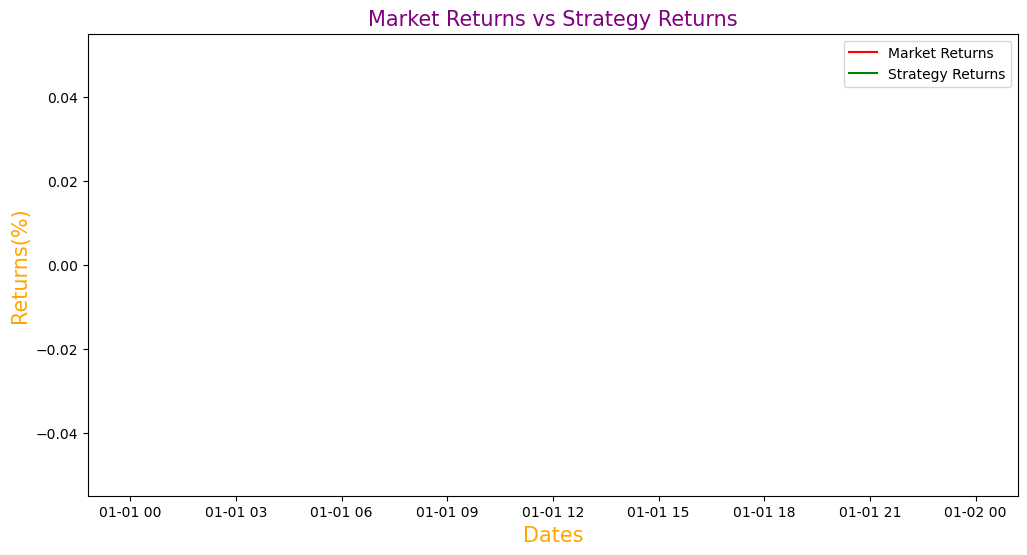

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(trade_price_stock['Cumulative_Market_Returns'], color='red', label='Market Returns')
plt.plot(trade_price_stock['Cumulative_Strategy_Returns'], color='green', label='Strategy Returns')

plt.title('Market Returns vs Strategy Returns', color='purple', size=15)

# Setting the axes labels for close prices plot
plt.xlabel('Dates', color='orange', fontsize=15)
plt.ylabel('Returns(%)', color='orange', fontsize=15)

plt.legend()
plt.show()